## Anycost GANs for Interactive Image Synthesis and Editing
In this notebook, we will show that anycost generator can give consistent outputs at various channel and resolution configuration. Here we used an anycost generator (config-F) trained on FFHQ dataset, supporting uniform channel reduction.

In [1]:
print('Installing PyTorch...')
! pip install torch 1>/dev/null
print('Installing torchvision...')
! pip install torchvision 1>/dev/null
print('Installing numpy...')
! pip install numpy 1>/dev/null
print('Installing tqdm (progress bar) ...')
! pip install tqdm 1>/dev/null
print('Installing matplotlib...')
! pip install matplotlib 1>/dev/null
print('All required packages have been successfully installed!')

# now clone the code
! git clone https://github.com/mit-han-lab/anycost-gan.git  # TODO
%cd anycost-gan

Installing PyTorch...
Installing torchvision...
Installing numpy...
Installing tqdm (progress bar) ...
Installing matplotlib...
All required packages have been successfully installed!
Cloning into 'anycost-gan'...
remote: Enumerating objects: 341, done.
remote: Counting objects: 100% (341/341), done.
remote: Compressing objects: 100% (255/255), done.
remote: Total 341 (delta 126), reused 295 (delta 80), pack-reused 0
Receiving objects: 100% (341/341), 25.06 MiB | 31.56 MiB/s, done.
Resolving deltas: 100% (126/126), done.
/content/anycost-gan


In [2]:
import os
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm_notebook as tqdm
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 200  # I would like to make it higher, but too slow
import matplotlib.pyplot as plt
import json
from PIL import Image, ImageFont, ImageDraw

import models
from models.dynamic_channel import set_sub_channel_config, set_uniform_channel_ratio, reset_generator

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
font_path = '/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf'

Ninja is required to load C++ extensions
 # Using native op...


### 1. Anycost GAN (uniform)
We first test the anycost generator (uniform channel setting). It supports **4 resolutions** and **4 channel widths**.

In [3]:
# load anycost generator (uniform)
g_ffhq = models.get_pretrained('generator', 'anycost-ffhq-config-f').to(device).eval()
g_car = models.get_pretrained('generator', 'anycost-car-config-f').to(device).eval()

Downloading: "https://hanlab.mit.edu/projects/anycost-gan/files/generator_anycost-ffhq-config-f.pt" to /root/.cache/torch/hub/checkpoints/generator_anycost-ffhq-config-f.pt


Downloading: "https://hanlab.mit.edu/projects/anycost-gan/files/generator_anycost-car-config-f.pt" to /root/.cache/torch/hub/checkpoints/generator_anycost-car-config-f.pt


Build the function to generate a $4\times4$ image grid using different channels and resolutions.

In [4]:
def torch_to_np_image(x):
    assert x.shape[0] == 1
    x = x.squeeze(0)
    return ((x.permute(1, 2, 0) + 1) * 0.5 * 255).cpu().numpy().astype('uint8')


def add_legend_to_figure(x, full_res):
    # add padding
    h, w, c = x.shape
    x_pad_rate = 0.1
    y_pad_rate = 0.05
    pad_h = int(h + h * y_pad_rate)
    pad_w = int(w + w * x_pad_rate)
    pad_x = np.zeros([pad_h, pad_w, c], dtype=x.dtype)
    pad_x[...] = (255)
    pad_x[-h:, -w:] = x
    # add text
    img = Image.fromarray(pad_x)
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype(font_path, int(100 * full_res / 1024))

    for i, text in enumerate(['1x', '0.75x', '0.5x', '0.25x']):
        text_w, text_h = draw.textsize(text, font=font)
        x_coord = x_pad_rate * w * 0.9 - text_w
        y_coord = (y_pad_rate + i * 1./4 + 1./8) * h - 0.5 * text_h
        draw.text((x_coord, y_coord), text, (0, 0, 0), font=font)

    for i in range(4):
        text = str(full_res // (2 ** i))
        text_w, text_h = draw.textsize(text, font=font)
        x_coord = (x_pad_rate + i * 1./4 + 1./8) * w - 0.5 * text_w
        y_coord = y_pad_rate * h * 0.9 - text_h
        draw.text((x_coord, y_coord), text, (0, 0, 0), font=font)

    return np.asarray(img)


def get_4x4_grid(g, latent, truncation=0.5, crop=False):
    """Generate the image grid using z code (latent)."""
    images = []
    full_resolution = g.resolution
    if truncation < 1:
        mean_style = g.mean_style(10000)
    else:
        mean_style = None
    with torch.no_grad():
        for channel_mult in [1, .75, .5, .25]:
            set_uniform_channel_ratio(g, channel_mult)
            _, all_rgbs = g(latent, return_rgbs=True, truncation=truncation, truncation_style=mean_style, randomize_noise=False)
            all_rgbs = all_rgbs[-4:][::-1]  # the largest 4 resolutions
            all_rgbs = [F.interpolate(rgb.clamp(-1, 1), size=(full_resolution, full_resolution), mode='bilinear', align_corners=True) for rgb in all_rgbs]
            if crop:  # for car dataset, crop out the padding of the image
                all_rgbs = [r[:, :, int(0.125 * full_resolution): -int(0.125 * full_resolution)] for r in all_rgbs]
            images.append(torch.cat(all_rgbs, dim=3))  # concat along width
    image_grid = torch.cat(images, dim=2)  # concat along height
    image_grid_np = torch_to_np_image(image_grid)
    return add_legend_to_figure(image_grid_np, full_resolution)

Now let us build an image grid on FFHQ dataset by using 4 resolutions and 4 channel widths.

(-0.5, 4504.5, 4299.5, -0.5)

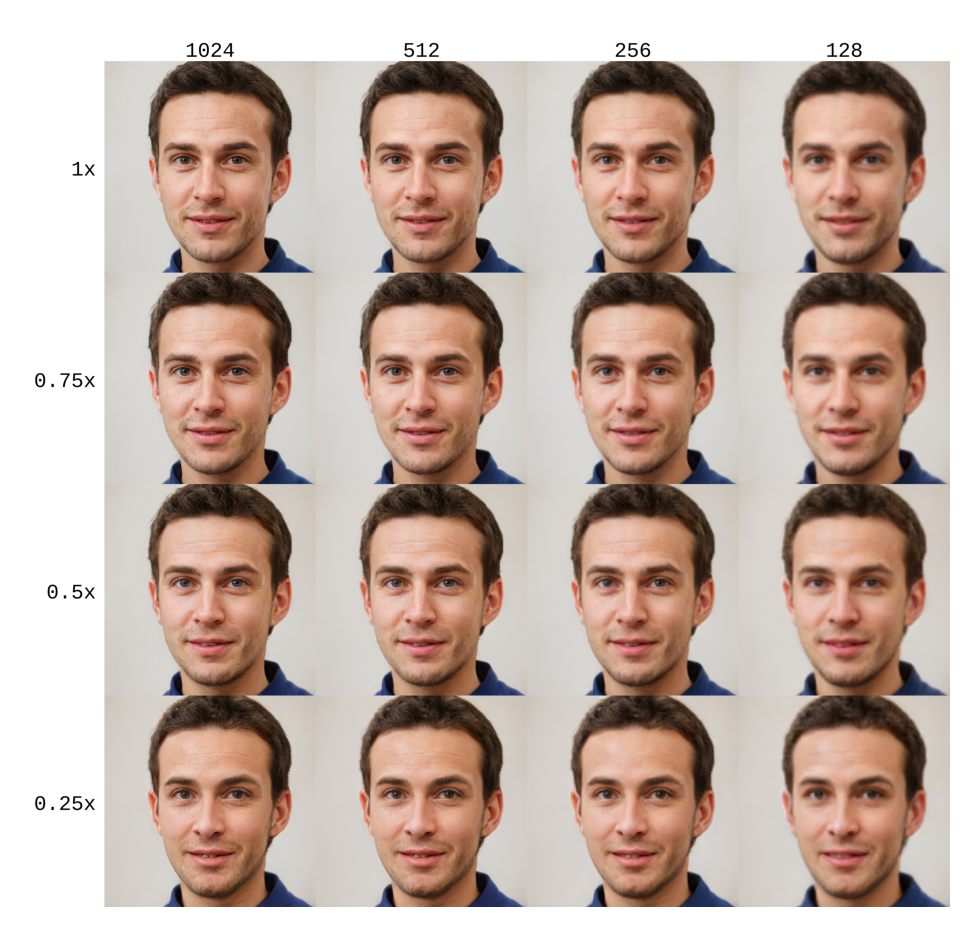

In [5]:
torch.manual_seed(1601)
latent = torch.randn(1, 1, 512, device=device)
img_out_np = get_4x4_grid(g_ffhq, latent)

plt.figure(figsize=(6, 6))
plt.imshow(img_out_np)
plt.axis('off')

Similarly, create a grid for the LSUN Car dataset.

(-0.5, 2251.5, 1611.5, -0.5)

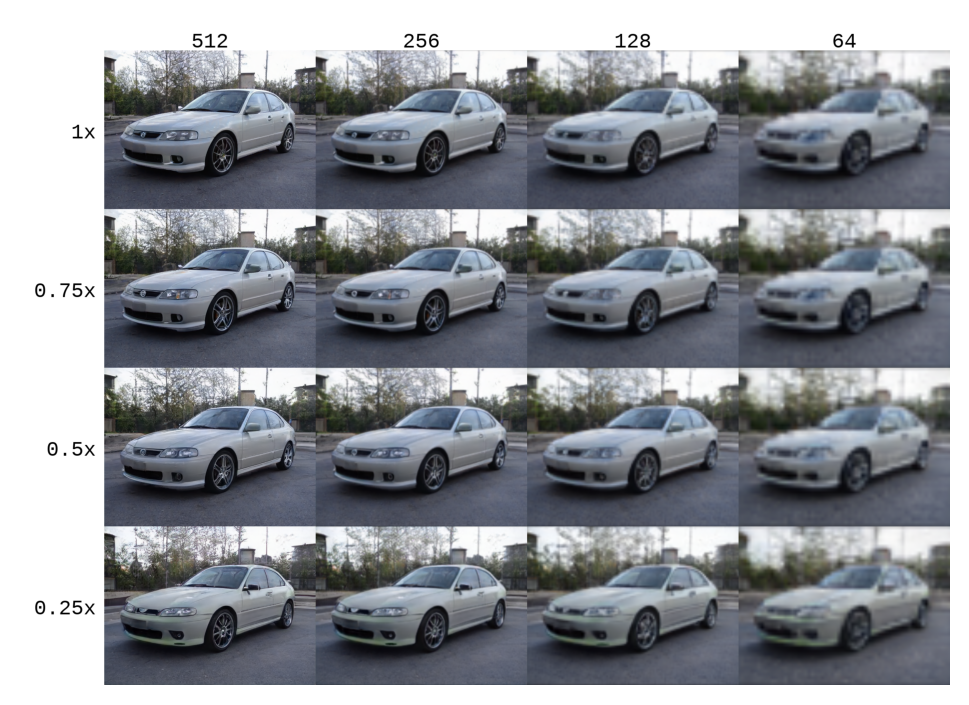

In [6]:
torch.manual_seed(9001)
latent = torch.randn(1, 1, 512, device=device)
img_out_np = get_4x4_grid(g_car, latent, crop=True)

plt.figure(figsize=(6, 6))
plt.imshow(img_out_np)
plt.axis('off')

### 2. Anycost GAN (flexible)
We first test the anycost generator (flexible channel setting). We used **evolutionary search** to search the best channel and resolution configuration under a certain computation budget, which achieves the highest consistency with the full generator. We can get fine-grained computation budgets with flexible setting.

In [7]:
# load anycost generator (flexible)
g_ffhq = models.get_pretrained('generator', 'anycost-ffhq-config-f-flexible').to(device).eval()

# load the evolution search results
with open(os.path.join('assets/evolve_configs/anycost-ffhq-config-f-flexible.json')) as f:
    evolve_cfgs = json.load(f)

cfg_keys = ['116G', '87G', '58G', '29G', '15G']

cfg_list = [evolve_cfgs[v] for v in cfg_keys]
full_macs = 144365170309  # computation for resolution 1024, config-F

Downloading: "https://hanlab.mit.edu/projects/anycost-gan/files/generator_anycost-ffhq-config-f-flexible.pt" to /root/.cache/torch/hub/checkpoints/generator_anycost-ffhq-config-f-flexible.pt


Generate the image using the full generator and add information bar.

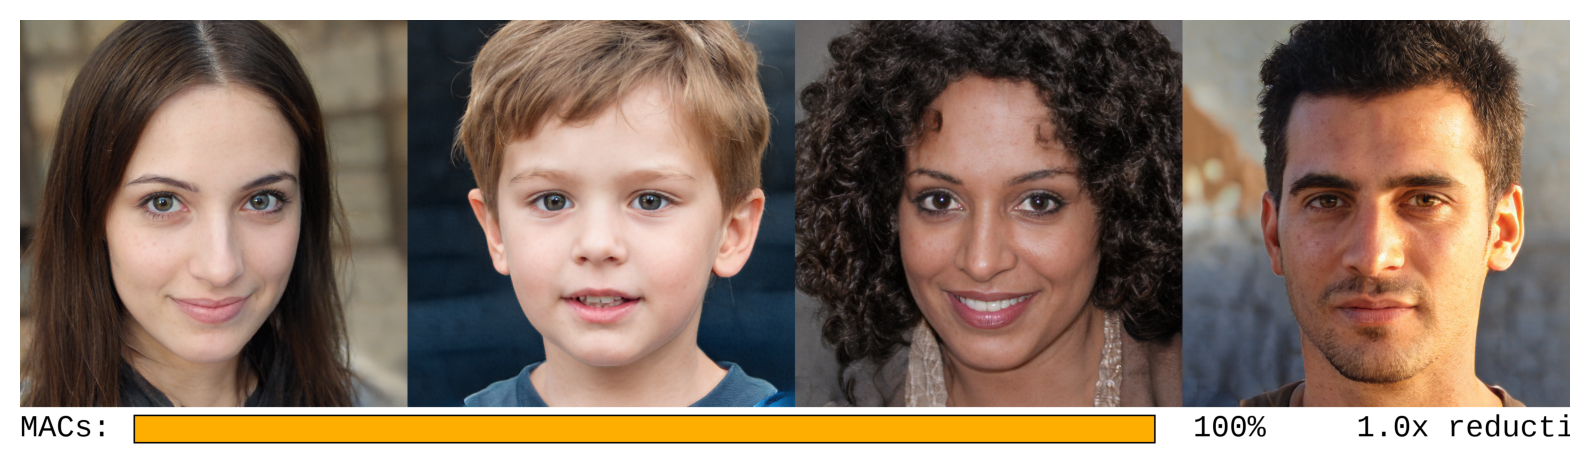

In [8]:
def get_img_row(g, latent, truncation=0.5):
    """Generate four images in a row."""
    with torch.no_grad():
        full_resolution = g.resolution
        if truncation < 1:
            mean_style = g.mean_style(10000)
        else:
            mean_style = None

        out, _ = g(latent, truncation=truncation, truncation_style=mean_style, randomize_noise=False)
        out = F.interpolate(out.clamp(-1, 1), size=(full_resolution, full_resolution), mode='bilinear', align_corners=True)
    n, c, h, w = out.shape
    out = out.permute(1, 2, 0, 3).contiguous().view(1, c, h, n * w)
    return torch_to_np_image(out)


def add_information(img, this_macs):
    # creat an empty padding
    img = Image.fromarray(img)
    pad = Image.fromarray(np.zeros([100, img.width, 3]).astype('uint8') + 255)
    # add information to the padding
    fnt = ImageFont.truetype(font_path, 80)
    # get a drawing context
    d = ImageDraw.Draw(pad)
    d.text((0, 10), "MACs:", font=fnt,  fill=(0, 0, 0, 128))
    bar_length = 3000
    d.rectangle([300, 20, (bar_length - 300) * this_macs/full_macs + 300, 95], fill=(254, 174, 0), outline=(0, 0, 0), width=0)
    d.rectangle([300, 20, bar_length, 95], fill=None, outline=(0, 0, 0), width=4)

    d.text((bar_length + 100, 10), f'{int(this_macs/full_macs*100)}%     {full_macs/this_macs:.1f}x reduction',
           font=fnt,  fill=(0, 0, 0, 128))
    dst = Image.new('RGB', (img.width, img.height + pad.height))
    dst.paste(img, (0, 0))
    dst.paste(pad, (0, img.height))
    return dst


seed_list = 50532,  52226, 9494, 52505
latent_list = []
for seed in seed_list:
    torch.manual_seed(seed)
    latent = torch.randn(1, 1, g_ffhq.style_dim, device=device)
    latent_list.append(latent)
latent_list = torch.cat(latent_list, dim=0)
img = get_img_row(g_ffhq, latent_list)
img_info = add_information(img, full_macs)
plt.figure(figsize=(10, 4))
plt.imshow(img_info)
plt.axis('off')


img_info_list = [img_info]
keys_list = ['100%']

Generate the images using generator of smaller computation.

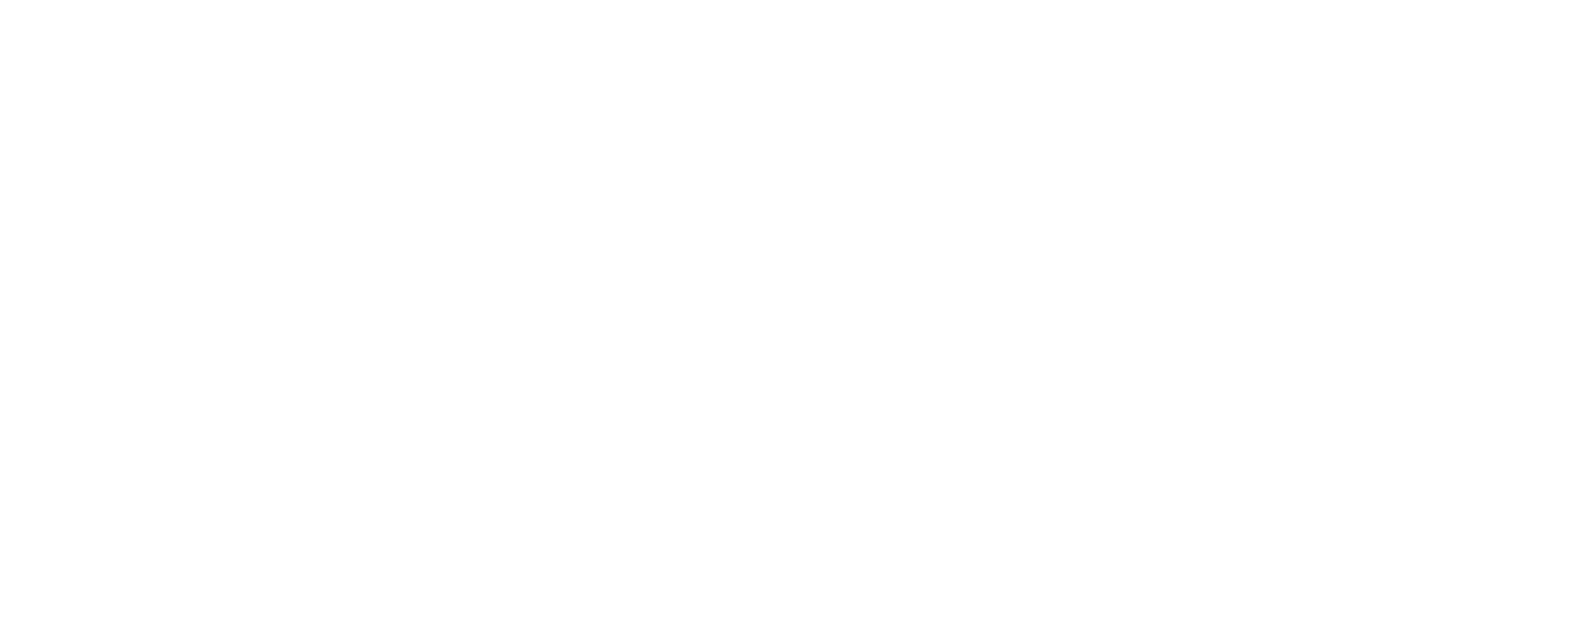

interactive(children=(SelectionSlider(description='Reduction', index=5, options=('10%', '19%', '39%', '59%', '…

<function __main__.show_image>

In [9]:
for cfg in cfg_list:
    set_sub_channel_config(g_ffhq, cfg['channels'])
    g_ffhq.target_res = cfg['res']
    img_row = get_img_row(g_ffhq, latent_list)
    reset_generator(g_ffhq)
    img_info_list.append(add_information(img_row, cfg['macs']))
    keys_list.append(f'{int(cfg['macs'] * 100. / full_macs)}%')

import ipywidgets as widgets
plt.figure(figsize=(10, 4))
plt.axis('off')


def show_image(key):
    img = img_info_list[keys_list.index(key)]
    plt.axis('off')
    plt.imshow(img)


widgets.interact(
    show_image,
    key=widgets.SelectionSlider(
        options=keys_list[::-1], value='100%', description='Reduction',  # continuous_update=False
    ),
)